In [1]:
import numpy as np
import os
from xml.etree import ElementTree
from xml.etree.ElementTree import XMLParser
from numpy import array
float32 = 'float32'
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [11]:
def drop_dollar(some_str):
    if some_str[0] == '$':
        return some_str[1::]
    else:
        return some_str    
    
def rect_diagonal(some_array):
    return [[int(some_array[0][0]), int(some_array[0][1])], [int(some_array[2][0]), int(some_array[2][1])]]    
    
    
def ground_true_answer(xml_file):
    tree = ElementTree.parse(xml_file)
    root = tree.getroot()
    symbols = ['♠','♥','♦️','♣','♦','♥','♠','♣'] 
    suite_list = []
    rang_list = []
    money_list = {}  
    card_list = {}
    for obj in root.findall('object'):
        for i in obj:
            if i.text == 'cards':
                suite =  (obj.findall('attributes')[0].text).split('=')[1]        
                a = (obj.findall('polygon')[0])            
                coord = []
                for i in a.findall('pt'):       
                    pair = []
                    for el in i:                
                        pair+=[int(float(el.text))]
                    coord +=[pair]
                if suite in symbols:
                    suite_list += [[suite, coord]]
                elif suite not in symbols:
                    rang_list += [[suite, coord]]

            elif i.text == 'money':
                money =  (obj.findall('attributes')[0].text).split('=')[1]
                a = (obj.findall('polygon')[0])            
                coord = []
                for i in a.findall('pt'):       
                    pair = []
                    for el in i:                
                        pair+=[int(float(el.text))]
                    coord +=[pair]            
                money_list[drop_dollar(money)]=rect_diagonal(coord)          
            # elif money                 
      
    for i in suite_list:
        for j in rang_list:
            if int(i[1][0][0])-10 < int(j[1][0][0]) < int(i[1][0][0]) + 10\
                        and int(i[1][0][1])-50 < int(j[1][0][1]) < int(i[1][0][1]) + 50:
                card_list[j[0]+i[0]] = [j[1][0], i[1][2]]
            
    return card_list, money_list


def predict_answer(predict):    
    card_list = {}
    money_list = {}
    symbols = ['♠','♥','♦️','♣','♦','♥','♠','♣'] 
    for i in predict:
        if i[0].startswith('$'):
            money_list[drop_dollar(i[0])] = rect_diagonal(i[1])
        elif len(i[0])==2 and i[0][1] in symbols:
            card_list[i[0]] = rect_diagonal(i[1])
        elif len(i[0])==3 and i[0][2] in symbols:
            card_list[i[0]] = rect_diagonal(i[1])
    return card_list, money_list


def debug(predict_array, ground_dict, predict_dict, save_dir, image_file): 
    wrong_answer = {}
    for key, val in ground_dict.items():
        if key not in predict_dict:     
            wrong_answer[key] = val
    #print (wrong_answer)
    for key, val in wrong_answer.items():
        compare = val
        x = compare[0][0]
        y = compare[0][1]
        for i in predict_array:
            first_point = (rect_diagonal(i[1])[0])
            x_pred = first_point[0]
            y_pred = first_point[1]   
            if x-10<x_pred<x+10 and y-10<y_pred<y+10:
                area = (val[0][0], val[0][1], val[1][0], val[1][1])
                wrong = drop_dollar(i[0])
                name = str(wrong)+'_pred_'+str(key)+'_true_'+'.jpg'
                image = Image.open(image_file)
                image.crop(area).save(save_dir+name)
                #print (wrong_answer, key, val)
    return (100 - (round(len(wrong_answer)*100/len(ground_dict),2)))

In [6]:
def answer_accuracy(ground_true_xml, predict_list, image_file, save_dir):    
    ground_true_data = ground_true_answer(ground_true_xml)
    predict_data = predict_answer(predict_list)    
    card_accuracy = debug(predict_list, ground_true_data[0],predict_data[0], save_dir, image_file)
    money_accuracy = debug(predict_list, ground_true_data[1], predict_data[1], save_dir, image_file)
    return card_accuracy, money_accuracy

## testing

In [7]:
home_dir = '/media/alex/Integral-ASIC/task_ggpokerok_groundtrue3categories-2020_10_21_12_52_30-labelme 3.0/default/'
test_dir = '/media/alex/Integral-ASIC/task_ggpokerok_groundtrue3categories-2020_10_21_12_52_30-labelme 3.0/test/'
images = [os.path.join(home_dir,i) for i in os.listdir(home_dir) if i .endswith('.jpg')]
xml = [os.path.join(home_dir,i) for i in os.listdir(home_dir) if i .endswith('.xml')]
print (images[2].split('/')[-1], xml[2].split('/')[-1])

image0000000202.jpg image0000000202.xml


In [12]:
answer_accuracy(xml[2],pred_202, images[2], test_dir)

(77.78, 71.43)

In [15]:
crop_images = [os.path.join(test_dir,i) for i in os.listdir(test_dir)]

<Figure size 1080x1800 with 0 Axes>

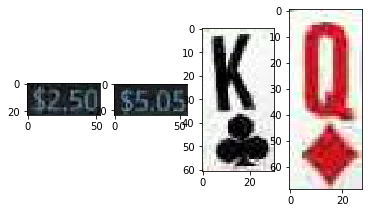

<Figure size 1080x1800 with 0 Axes>

In [17]:
f, axarr = plt.subplots(1,4) 
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(Image.open(crop_images[0]))
axarr[1].imshow(Image.open(crop_images[1]))
axarr[2].imshow(Image.open(crop_images[2]))
axarr[3].imshow(Image.open(crop_images[3]))
plt.figure(figsize=(15, 25))

In [9]:
pred_202 = [('88', array([[683.75,  25.  ],
         [705.  ,  25.  ],
         [705.  ,  72.5 ],
         [683.75,  72.5 ]], dtype=float32)),
 ('$20.000', array([[240.0841  ,  26.023823],
         [358.9926  ,  27.568089],
         [358.59338 ,  58.309654],
         [239.68488 ,  56.76539 ]], dtype=float32)),
 ('aily', array([[155.  ,  28.75],
         [237.5 ,  28.75],
         [237.5 ,  52.5 ],
         [155.  ,  52.5 ]], dtype=float32)),
 ('eaderboard', array([[360.  ,  28.75],
         [560.  ,  28.75],
         [560.  ,  52.5 ],
         [360.  ,  52.5 ]], dtype=float32)),
 ('', array([[640.  ,  33.75],
         [673.75,  33.75],
         [673.75,  58.75],
         [640.  ,  58.75]], dtype=float32)),
 ('38', array([[306.25, 158.75],
         [326.25, 158.75],
         [326.25, 173.75],
         [306.25, 173.75]], dtype=float32)),
 ('invisman', array([[318.80096, 178.80313],
         [402.827  , 180.55371],
         [402.4382 , 199.2175 ],
         [318.41214, 197.46692]], dtype=float32)),
 ('$2.', array([[333.75, 201.25],
         [362.5 , 201.25],
         [362.5 , 221.25],
         [333.75, 221.25]], dtype=float32)),
 ('50', array([[358.75, 202.5 ],
         [387.5 , 202.5 ],
         [387.5 , 221.25],
         [358.75, 221.25]], dtype=float32)),
 ('6♠', array([[608.75, 307.5 ],
         [632.5 , 307.5 ],
         [632.5 , 366.25],
         [608.75, 366.25]], dtype=float32)),
 ('♣', array([[556.1416 , 312.01303],
         [581.62463, 308.95508],
         [588.8053 , 368.7934 ],
         [563.32227, 371.85135]], dtype=float32)),
 ('♠', array([[625.  , 353.75],
         [661.25, 353.75],
         [661.25, 395.  ],
         [625.  , 395.  ]], dtype=float32)),
 ('', array([[582.5, 372.5],
         [602.5, 372.5],
         [602.5, 395. ],
         [582.5, 395. ]], dtype=float32)),
 ('11', array([[556.25, 375.  ],
         [577.5 , 375.  ],
         [577.5 , 392.5 ],
         [556.25, 392.5 ]], dtype=float32)),
 ('18', array([[ 46.25, 376.25],
         [ 67.5 , 376.25],
         [ 67.5 , 392.5 ],
         [ 46.25, 392.5 ]], dtype=float32)),
 ('ih8poker', array([[ 53.81839, 397.14694],
         [155.24855, 398.83746],
         [154.89934, 419.79   ],
         [ 53.46918, 418.0995 ]], dtype=float32)),
 ('evgenyo788', array([[556.8956 , 402.66925],
         [674.6589 , 396.24585],
         [675.9394 , 419.7215 ],
         [558.17615, 426.1449 ]], dtype=float32)),
 ('0.02', array([[340.22336, 413.29913],
         [395.66174, 415.14706],
         [394.8418 , 439.74475],
         [339.4034 , 437.89685]], dtype=float32)),
 ('lolderm', array([[261.80173, 414.37073],
         [341.08618, 419.0345 ],
         [339.71555, 442.33618],
         [260.43103, 437.67242]], dtype=float32)),
 ('0.05', array([[394.31866, 417.28583],
         [458.5506 , 414.81537],
         [459.44058, 437.95425],
         [395.20862, 440.42474]], dtype=float32)),
 ('$5.05.', array([[ 77.50001, 422.49997],
         [140.     , 422.49997],
         [140.     , 442.49997],
         [ 77.50001, 442.49997]], dtype=float32)),
 ('$0.94', array([[590.  , 422.5 ],
         [643.75, 422.5 ],
         [643.75, 443.75],
         [590.  , 443.75]], dtype=float32)),
 ('1otal', array([[316.25, 453.75],
         [367.5 , 453.75],
         [367.5 , 475.  ],
         [316.25, 475.  ]], dtype=float32)),
 ('ot', array([[367.5 , 455.  ],
         [403.75, 455.  ],
         [403.75, 475.  ],
         [367.5 , 475.  ]], dtype=float32)),
 ('$0.10', array([[328.75, 473.75],
         [392.5 , 473.75],
         [392.5 , 497.5 ],
         [328.75, 497.5 ]], dtype=float32)),
 ('10♣', array([[413.75, 525.  ],
         [446.25, 525.  ],
         [446.25, 592.5 ],
         [413.75, 592.5 ]], dtype=float32)),
 ('♦', array([[150.  , 526.25],
         [173.75, 526.25],
         [173.75, 591.25],
         [150.  , 591.25]], dtype=float32)),
 ('2♣', array([[238.75, 526.25],
         [266.25, 526.25],
         [266.25, 591.25],
         [238.75, 591.25]], dtype=float32)),
 ('7♠', array([[327.5 , 526.25],
         [353.75, 526.25],
         [353.75, 591.25],
         [327.5 , 591.25]], dtype=float32)),
 ('5♠', array([[505.  , 526.25],
         [531.25, 526.25],
         [531.25, 590.  ],
         [505.  , 590.  ]], dtype=float32)),
 ('♦', array([[172.5, 575. ],
         [217.5, 575. ],
         [217.5, 627.5],
         [172.5, 627.5]], dtype=float32)),
 ('♠', array([[526.25, 575.  ],
         [576.25, 575.  ],
         [576.25, 626.25],
         [526.25, 626.25]], dtype=float32)),
 ('♣', array([[257.5, 575. ],
         [310. , 575. ],
         [310. , 627.5],
         [257.5, 627.5]], dtype=float32)),
 ('♠', array([[348.75, 576.25],
         [397.5 , 576.25],
         [397.5 , 625.  ],
         [348.75, 625.  ]], dtype=float32)),
 ('♣', array([[437.5 , 576.25],
         [487.5 , 576.25],
         [487.5 , 627.5 ],
         [437.5 , 627.5 ]], dtype=float32)),
 ('$0.10', array([[326.25, 656.25],
         [385.  , 656.25],
         [385.  , 682.5 ],
         [326.25, 682.5 ]], dtype=float32)),
 ('3♦', array([[605.5979 , 700.6499 ],
         [628.63086, 701.6096 ],
         [626.01166, 764.4693 ],
         [602.97876, 763.5095 ]], dtype=float32)),
 ('9♦', array([[547.967  , 707.3303 ],
         [572.0144 , 704.1937 ],
         [580.0023 , 765.43445],
         [555.9549 , 768.57104]], dtype=float32)),
 ('4', array([[577.5 , 752.5 ],
         [598.75, 752.5 ],
         [598.75, 787.5 ],
         [577.5 , 787.5 ]], dtype=float32)),
 ('$20000', array([[368.75, 761.25],
         [447.5 , 761.25],
         [447.5 , 786.25],
         [368.75, 786.25]], dtype=float32)),
 ('iotal', array([[251.25, 765.  ],
         [300.  , 765.  ],
         [300.  , 785.  ],
         [251.25, 785.  ]], dtype=float32)),
 ('rzx', array([[302.5 , 765.  ],
         [350.  , 765.  ],
         [350.  , 786.25],
         [302.5 , 786.25]], dtype=float32)),
 ('37', array([[ 46.25, 775.  ],
         [ 67.5 , 775.  ],
         [ 67.5 , 792.5 ],
         [ 46.25, 792.5 ]], dtype=float32)),
 ('43', array([[548.75, 775.  ],
         [571.25, 775.  ],
         [571.25, 792.5 ],
         [548.75, 792.5 ]], dtype=float32)),
 ('sv88', array([[ 73.75, 797.5 ],
         [143.75, 797.5 ],
         [143.75, 818.75],
         [ 73.75, 818.75]], dtype=float32)),
 ('y', array([[255.  , 798.75],
         [290.  , 798.75],
         [290.  , 820.  ],
         [255.  , 820.  ]], dtype=float32)),
 ('oimsl', array([[290.  , 798.75],
         [363.75, 798.75],
         [363.75, 818.75],
         [290.  , 818.75]], dtype=float32)),
 ('ellowping', array([[555.3344 , 795.63696],
         [669.42993, 799.71185],
         [668.55585, 824.1895 ],
         [554.46027, 820.1147 ]], dtype=float32)),
 ('', array([[382.5 , 798.75],
         [408.75, 798.75],
         [408.75, 820.  ],
         [382.5 , 820.  ]], dtype=float32)),
 ('$6.23', array([[ 76.25, 822.5 ],
         [138.75, 822.5 ],
         [138.75, 848.75],
         [ 76.25, 848.75]], dtype=float32)),
 ('$4.05', array([[581.25, 822.5 ],
         [642.5 , 822.5 ],
         [642.5 , 848.75],
         [581.25, 848.75]], dtype=float32)),
 ('y', array([[265.  , 830.  ],
         [298.75, 830.  ],
         [298.75, 857.5 ],
         [265.  , 857.5 ]], dtype=float32)),
 ('rnw', array([[301.25, 831.25],
         [353.75, 831.25],
         [353.75, 856.25],
         [301.25, 856.25]], dtype=float32)),
 ('0', array([[  73.75, 1061.25],
         [  90.  , 1061.25],
         [  90.  , 1080.  ],
         [  73.75, 1080.  ]], dtype=float32)),
 ('ol', array([[ 101.25, 1088.75],
         [ 142.5 , 1088.75],
         [ 142.5 , 1113.75],
         [ 101.25, 1113.75]], dtype=float32)),
 ('inn', array([[ 148.75, 1091.25],
         [ 192.5 , 1091.25],
         [ 192.5 , 1113.75],
         [ 148.75, 1113.75]], dtype=float32)),
 ('$1', array([[ 127.5 , 1120.  ],
         [ 161.25, 1120.  ],
         [ 161.25, 1151.25],
         [ 127.5 , 1151.25]], dtype=float32)),
 ('wait', array([[ 446.24997, 1210.     ],
         [ 508.74997, 1210.     ],
         [ 508.74997, 1235.     ],
         [ 446.24997, 1235.     ]], dtype=float32)),
 ('for', array([[ 511.25, 1211.25],
         [ 555.  , 1211.25],
         [ 555.  , 1235.  ],
         [ 511.25, 1235.  ]], dtype=float32)),
 ('linds', array([[ 556.25, 1210.  ],
         [ 637.5 , 1210.  ],
         [ 637.5 , 1235.  ],
         [ 556.25, 1235.  ]], dtype=float32)),
 ('♦', array([[ 406.25, 1215.  ],
         [ 426.25, 1215.  ],
         [ 426.25, 1233.75],
         [ 406.25, 1233.75]], dtype=float32))]